#Импортирование необходиммых библиотек. Загрузка датасета.

Импорт библиотек. Это задача классификации, поэтому имеет смысл использовать модели для классификации. Для начала используем Логистическую регрессию, ансаблевые модели (в том числе и catboost).

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

Данные были выгружены в папку с кодом, поэтому подключать библиотеку для чтение из гугл диска или подобных сервисов нет смысла.

In [5]:
train = pd.read_csv('train_spam.csv')
test = pd.read_csv('test_spam.csv')

#1) Базовый визуальный анализ

In [6]:
train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [7]:
test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [8]:
train.shape

(16278, 2)

In [9]:
test.shape

(4070, 1)

In [10]:
train.dtypes

text_type    object
text         object
dtype: object

In [11]:
test.dtypes

text    object
dtype: object

In [12]:
print(f"Нулевые значнения в train: {train.isnull().sum()}")
print(f"Нулевые значнения в test: {test.isnull().sum()}")

Нулевые значнения в train: text_type    0
text         0
dtype: int64
Нулевые значнения в test: text    0
dtype: int64


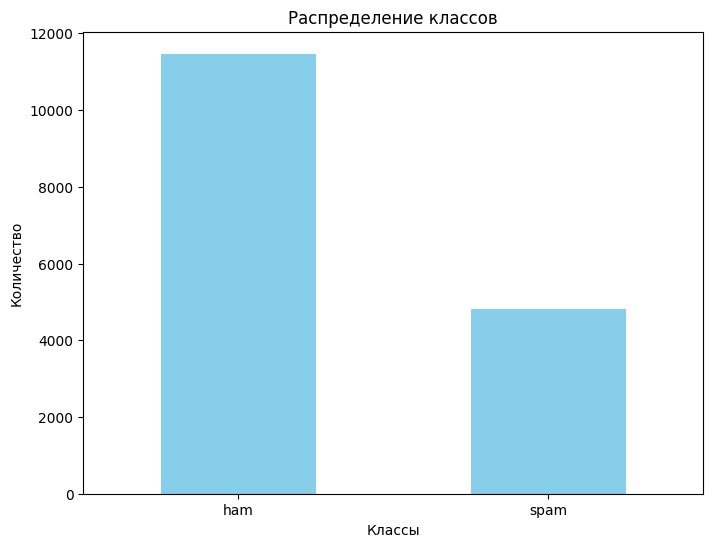

In [13]:
class_counts = train['text_type'].value_counts()

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение классов')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

Из графика можно сделать вывод, что метки не сбалансированы. Можно использовать градиентный бустниг и случайный лес, они хорошо себя показывают на не сбалансированных классах.

**1) Размер данных:**

  Тренировочный набор данных содержит 16000 строк и 2 колонки.
  Тестовый набор данных содержит 4000 строк и 1 колонку.

**2) Типы данных:**

  В тренировочном наборе данных одна колонка имеет тип text_type со значением object, а другая колонка также имеет тип object.  В тестовом наборе данных есть только одна колонка с текстом сообщений, также имеющая тип object.

**3) Пропущенные значения:**

  В тренировочном наборе данных отсутствуют пропущенные значения в обеих колонках.
  В тестовом наборе данных также отсутствуют пропущенные значения.





## Вывод по анализу
Исходя из того, что в тестовом наборе данных отсутствуют метки для текстовых сообщений, то мы можем предположить, что это задача обучения без учителя или задача кластеризации. Однако есть вариант, что это задача на обучение с учителем, где мы можем использовать обычные модели. Для точного результата необходимо получить больше информации.

#Предобработка данных

Для начала мы преобразуем метки в бинарные числа: 0 и 1

In [14]:
label_mapping = {'ham': 0, 'spam': 1}

train['text_type'] = train['text_type'].map(label_mapping)


In [15]:
train.head()

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...


Преобразование прошло успешно, далее нам надо предобработать текст

Мы начнем с токенизации и регистра.

In [16]:
nltk.download('stopwords')
nltk.download('punkt')

train['text'] = train['text'].apply(lambda x: word_tokenize(x))
train['text'] = train['text'].apply(lambda x: [word.lower() for word in x])

train.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,text_type,text
0,0,"[make, sure, alex, knows, his, birthday, is, o..."
1,0,"[a, resume, for, john, lavorato, thanks, vince..."
2,1,"[plzz, visit, my, website, moviesgodml, to, ge..."
3,1,"[urgent, your, mobile, number, has, been, awar..."
4,0,"[overview, of, hr, associates, analyst, projec..."


Далее мы удалим стоп слова, чтобы они не влияли на нашу модель.

In [17]:
stop_words = set(stopwords.words('english'))
train['text'] = train['text'].apply(lambda x: [word for word in x if word not in stop_words])

train.head()

,text_type,text
0,0,"[make, sure, alex, knows, birthday, fifteen, m..."
1,0,"[resume, john, lavorato, thanks, vince, get, m..."
2,1,"[plzz, visit, website, moviesgodml, get, movie..."
3,1,"[urgent, mobile, number, awarded, £2000, prize..."
4,0,"[overview, hr, associates, analyst, project, p..."


Теперь мы приведем слова к общему виду с помощью лемматизации.

In [18]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

train['text'] = train['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

train.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text_type,text
0,0,"[make, sure, alex, know, birthday, fifteen, mi..."
1,0,"[resume, john, lavorato, thanks, vince, get, m..."
2,1,"[plzz, visit, website, moviesgodml, get, movie..."
3,1,"[urgent, mobile, number, awarded, £2000, prize..."
4,0,"[overview, hr, associate, analyst, project, pe..."


Заключительная часть предобработки: векторизация. Мы преобразуем слова в числовой формат.

In [19]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(train['text'].apply(lambda x: ' '.join(x)))

print("Размерность матрицы после TF-IDF преобразования:", X_train_tfidf.shape)

Размерность матрицы после TF-IDF преобразования: (16278, 50439)


#Gradient Boosting. Обучение модели

In [20]:
gbModel = GradientBoostingClassifier()
gbModel.fit(X_train_tfidf, train['text_type'])

GradientBoostingClassifier()

Так же векторизируем тестовую выборку, как и трейновую. А далее прогнозируем результаты

In [21]:
X_test_tfidf = tfidf_vectorizer.transform(test['text'].apply(lambda x: ' '.join(x)))

In [22]:
y_pred_test = gbModel.predict(X_test_tfidf)

In [23]:
print("Прогнозы для тестового набора данных:\n", y_pred_test)

Прогнозы для тестового набора данных:
 [0 0 0 ... 0 0 0]


Тут мы получаем вероятности принадлежности, для дальнейшего использования в ROC-AUC, но данная метрика у нас не пошла, поэтому мы попытаемся пойти другим путем. Мы воспользуемся методом кросс-валидации и оценим ROC-AUC на трейновом наборе.

In [24]:
y_pred_proba = gbModel.predict_proba(X_test_tfidf)

In [25]:
from sklearn.model_selection import cross_val_score

roc_auc_scores = cross_val_score(gbModel, X_train_tfidf, train['text_type'], cv=5, scoring='roc_auc')

print("Средний ROC-AUC score по кросс-валидации:", roc_auc_scores.mean())


Средний ROC-AUC score по кросс-валидации: 0.9415714711308312


Получился очень хороший результат - 0,94

Использовали встроенную метрику score

In [26]:
test_score = gbModel.score(X_test_tfidf, y_pred_test)
print("Тестовый score:", test_score)


Тестовый score: 1.0


Мера качества модели показала 1.0

Для сравнения мы добавим модели Логической Регресии и Метод опорных векторов, чтобы сравнить результаты. На данный момент предположение, что градиентный бустинг покажет себя лучше этих моделей, так он лучше справляется с несбалансированными данными

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Логистическая регрессия
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, train['text_type'])

# Метод опорных векторов (SVM)
svm_model = SVC(probability=True)
svm_model.fit(X_train_tfidf, train['text_type'])


SVC(probability=True)

Метрики Логистической Регрессии

In [28]:
lr_test_score = lr_model.score(X_test_tfidf, y_pred_test)
lr_roc_auc_scores = cross_val_score(lr_model, X_train_tfidf, train['text_type'], cv=5, scoring='roc_auc')

Метрики Опорных Векторов

In [29]:
svm_test_score = svm_model.score(X_test_tfidf, y_pred_test)
svm_roc_auc_scores = cross_val_score(svm_model, X_train_tfidf, train['text_type'], cv=5, scoring='roc_auc')

Вывод резульатов

In [30]:
print("Производительность логистической регрессии:")
print("Тестовый score:", lr_test_score)
print("Средний ROC-AUC score по кросс-валидации:", lr_roc_auc_scores.mean())
print("\nПроизводительность метода опорных векторов (SVM):")
print("Тестовый score:", svm_test_score)
print("Средний ROC-AUC score по кросс-валидации:", svm_roc_auc_scores.mean())

Производительность логистической регрессии:
Тестовый score: 1.0
Средний ROC-AUC score по кросс-валидации: 0.9758199971772059

Производительность метода опорных векторов (SVM):
Тестовый score: 1.0
Средний ROC-AUC score по кросс-валидации: 0.9830566164747949


SVM модель себя показывает очень медленно. Время выполнения приблизительно 30 минут, так что даже с учетом очень хорошего скора, из-за своей скорости модель очень сильно проигрывает остальным моделям.

#Random Forest

Ансамбли очень хорошо себя показывают на различных задачах, поэтому, это будет сравнение случайного леса и градиентного бустинга.

In [31]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, train['text_type'])

RandomForestClassifier()

In [32]:
rf_test_score = rf_model.score(X_test_tfidf, y_pred_test)
rf_roc_auc_scores = cross_val_score(rf_model, X_train_tfidf, train['text_type'], cv=5, scoring='roc_auc')

In [33]:
print("Тестовый score:", rf_test_score)
print("Средний ROC-AUC score по кросс-валидации:", rf_roc_auc_scores.mean())

Тестовый score: 1.0
Средний ROC-AUC score по кросс-валидации: 0.980191921751399


#CATBOOST. Финальная модель.

Кэтбуст это невероятно эффективная модель, она основана на градиентной спуске. Но ради чистоты эксперимента, чтоб понять точный результат градиентного бустинга, лучше использовать эту библиотеку, а не стандартную sklearn.

In [34]:
catboost_model = CatBoostClassifier()
catboost_model.fit(X_train_tfidf, train['text_type'], verbose=False)

In [35]:
catboost_test_score = catboost_model.score(X_test_tfidf, y_pred_test)
catboost_roc_auc_scores = cross_val_score(catboost_model, X_train_tfidf, train['text_type'], cv=5, scoring='roc_auc')

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.6164673	total: 1.92s	remaining: 6m 21s
5:	learn: 0.6093718	total: 2.27s	remaining: 6m 15s
6:	learn: 0.5961258	total: 2.63s	remaining: 6m 13s
7:	learn: 0.5891189	total: 2.99s	remaining: 6m 10s
8:	learn: 0.5828096	total: 3.33s	remaining: 6m 7s
9:	learn: 0.5756833	total: 3.68s	remaining: 6m 4s
10:	learn: 0.5700527	total: 4.03s	remaining: 6m 2s
11:	learn: 0.5648450	total: 4.37s	remaining: 5m 59s
12:	learn: 0.5598635	total: 4.71s	remaining: 5m 57s
13:	learn: 0.5557117	total: 5.08s	remaining: 5m 57s
14:	learn: 0.5513459	total: 5.6s	remaining: 6m 8s
15:	learn: 0.5465092	total: 6.22s	remaining: 6m 22s
16:	learn: 0.5415539	total: 6.77s	remaining: 6m 31s
17:	learn: 0.5372521	total: 7.3s	remaining: 6m 38s
18:	learn: 0.5334273	total: 7.76s	remaining: 6m 40s
19:	learn: 0.5264404	total: 8.1s	remaining: 6m 36s
20:	learn: 0.5228425	total: 8.45s	remaining: 6m 33s
21:	learn: 0.5194050	total: 8.78s	remaining: 6m 30s
22:	learn

In [36]:
print("Тестовый score:", catboost_test_score)
print("Средний ROC-AUC score по кросс-валидации:", catboost_roc_auc_scores.mean())

Тестовый score: 1.0
Средний ROC-AUC score по кросс-валидации: 0.9759639058688743


#Результаты

Итого, у нас есть

1.   градиентный бустинг sklearn: 0,941
2.   логистическая регрессия: 0,975
3.   метод опорных векторов: 0,983
4.   случайный лес: 0,980
4.   кэтбустинг: 0,975





In [50]:
test_predictions = catboost_model.predict(X_test_tfidf)

In [51]:
if 1 in test_predictions:
  print(2)

In [46]:
import re

# Очистка текста от недопустимых символов и замена конкретных символов
def clean_text(text):
    # Замена конкретных недопустимых символов
    text = text.replace("\x96", " ")
    # Очистка текста от остальных недопустимых символов
    return re.sub(r'[^\x00-\x7F]+', '', text)

# Применение очистки ко всем текстовым столбцам тестового набора данных
test['text'] = test.apply(lambda row: clean_text(row['text']), axis=1)

# Создание DataFrame с текстом и предсказаниями
results_df = pd.DataFrame({'Score': test_predictions, 'Text': test['text']})

# Сохранение результатов в Excel файл
results_df.to_excel('submission.xlsx', index=False)




IllegalCharacterError: real options conference in cambridge steve thanks for agreeing to talk i attach the program to see the other speakers and style it is addressed to a professional autience please give me a suitable title for the talk replacing kaminski  s slot on july 6 energy session and the details of your position thanks lenos at 05 01 04 20 00 0100 steven leppard wrote dear prof trigeorgis vince kaminski has suggested that i would be a suitable speaker at your july conference in cambridge and i d be happy to come along if required please could you send me appropriate details and the audience type expected many thanks yours sincerely steve leppard4 thconfsessions doc lenos trigeorgis professor of finance university of cyprus dept of b cannot be used in worksheets.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

drive_path = '/content/drive/My Drive/'

results_df.to_excel(drive_path + 'submission.xlsx', index=False)
